# Preamble

In [1]:
%cd ../../../..
%pwd

/home/andrej/myStuff/berkeley/STAT215A/assignments/final


'/home/andrej/myStuff/berkeley/STAT215A/assignments/final'

In [2]:
import os
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

import imodels

from rulevetting.api import validation

from rulevetting.projects.tbi_pecarn.dataset import *

## Loading Data with Default Judgement Calls

In [3]:
dset = Dataset()

# Basic Model - `rulefit` rule set , minimal data set

Union / drop whenever possible

In [4]:
judg_calls = \
    {
        'clean_data'      : {},
        'preprocess_data' : {
            # Unioning policies:
            # 1: union - impute parent from children, drop children
            # 2: mixed: keep (some) children & parent, impute parent from the children kept
            # 3: no: no imputation, keep all children, drop those with N/A in any child
            # Include how the injury occurred
            "step1_injMech"   : False,
            "step5_missSubGCS": True,
            "step5_fake15GCS" : True,
            "step5_fake14GCS" : False,
            # GCS < 15, or other signs of altered mental status
            "step7_AMS"       : 1,
            # Evidence of substantial non-head injuries
            "step8_OSI"       : 1,
            # Raised scalp hematoma or swelling?
            "step9_HEMA"      : 1,
            # Palpable skull fracture?
            "step10_SFx"      : 1,
            # Signs of basilar skull fracture?
            "step11_SFxBas"   : 1,
            # Evidence of trauma above the clavicles
            "step12_Clav"     : 1,
            # Evidence of neurological deficit, besides altered mental status
            "step13_NeuroD"   : 1,
            # Whether the individual vomited after the injury
            "step14_Vomit"    : 1,
            # Whether there was a headache at the time of evaluation
            "step15_HA"       : 1,
            # only affects 3 above
            "step15_HAStart"  : False,
            # Whether there was a seizure
            "step16_Seiz"     : 1,
            # only affects 3 above
            "step16_SeizOccur": False,
            # History of loss of consciousness
            "step17_LOC"      : 1,
            # Clinical suspicion for alcohol or drug intoxication
            "step19_Drugs"    : False,
            # Whether the parent thinks the child is acting normally
            "step20_ActNormal": True

        },
        'extract_features': {
            "HEMA_umbrella"   : False,
            "SFxPalp_umbrella": False,
            "SFxBas_umbrella" : False,
            "AMS_umbrella"    : False,
            "OSI_umbrella"    : False,
            "Clav_umbrella"   : False,
            "NeuroD_umbrella" : False,
            "Vomit_umbrella"  : False,
            "HA_umbrella"     : False,
            "Seiz_umbrella"   : False,
            "LOC_umbrella"    : False,
            # binarize GCS
            "GCS"             : False,
            # remove columns with const values
            "remove_constVal" : True
        },
    }

In [5]:
df_train, df_tune, df_test = dset.get_data(split_age=AgeSplit.NOSPLIT ,**judg_calls)

kwargs {'clean_data': {}, 'preprocess_data': {'step1_injMech': False, 'step5_missSubGCS': True, 'step5_fake15GCS': True, 'step5_fake14GCS': False, 'step7_AMS': 1, 'step8_OSI': 1, 'step9_HEMA': 1, 'step10_SFx': 1, 'step11_SFxBas': 1, 'step12_Clav': 1, 'step13_NeuroD': 1, 'step14_Vomit': 1, 'step15_HA': 1, 'step15_HAStart': False, 'step16_Seiz': 1, 'step16_SeizOccur': False, 'step17_LOC': 1, 'step19_Drugs': False, 'step20_ActNormal': True}, 'extract_features': {'HEMA_umbrella': False, 'SFxPalp_umbrella': False, 'SFxBas_umbrella': False, 'AMS_umbrella': False, 'OSI_umbrella': False, 'Clav_umbrella': False, 'NeuroD_umbrella': False, 'Vomit_umbrella': False, 'HA_umbrella': False, 'Seiz_umbrella': False, 'LOC_umbrella': False, 'GCS': False, 'remove_constVal': True}}


In [6]:
print(len(df_train), len(df_tune), len(df_test))

2050 684 684


In [7]:
feature_names = list(df_train)
for col in dset.get_meta_keys() + [dset.get_outcome_name()]:
    try:
        feature_names.remove(col)
    except ValueError:
        pass

In [8]:
feature_names

['LOCSeparate',
 'Seiz',
 'ActNorm',
 'HA_verb',
 'Vomit',
 'GCSTotal',
 'AMS',
 'SFxPalp',
 'SFxBas',
 'Hema',
 'Clav',
 'NeuroD',
 'OSI',
 'AgeinYears',
 'High_impact_InjSev_1',
 'High_impact_InjSev_2',
 'High_impact_InjSev_3',
 'Amnesia_verb_0',
 'Amnesia_verb_1',
 'Amnesia_verb_91']

In [9]:
any(pd.isna(df_train.loc[:, feature_names]))

True

In [10]:
np.sum(pd.isna(df_train.loc[:, feature_names]))

LOCSeparate             0
Seiz                    0
ActNorm                 0
HA_verb                 0
Vomit                   0
GCSTotal                0
AMS                     0
SFxPalp                 0
SFxBas                  0
Hema                    0
Clav                    0
NeuroD                  0
OSI                     0
AgeinYears              0
High_impact_InjSev_1    0
High_impact_InjSev_2    0
High_impact_InjSev_3    0
Amnesia_verb_0          0
Amnesia_verb_1          0
Amnesia_verb_91         0
dtype: int64

In [23]:
rulefit = imodels.RuleFitClassifier(max_rules=10)
rulefit.fit(df_train.loc[:, feature_names], df_train.outcome, feature_names=feature_names)

RuleFitClassifier(max_rules=10)

In [12]:
def predict_and_save(model, model_name, X_train, X_tune, y_train, y_tune):
    '''Plots cv and returns cv, saves all stats
    '''
    
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes

    return stats, threshes

100%|██████████| 6/6 [00:00<00:00, 911.81it/s]


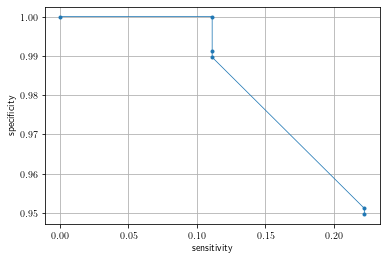

In [24]:
stats, threshes = predict_and_save(rulefit, 'rulefit',
                                   df_train.loc[:, feature_names],
                                   df_tune.loc[:, feature_names],
                                   df_train.outcome,
                                   df_tune.outcome)

In [14]:
# TODO: check what the linear is 

In [25]:
rules = rulefit.get_rules()
rules = rules[rules['type']!='linear']
rules = rules.sort_values('importance', ascending=False) 
rules

,rule,type,coef,support,importance
24,SFxBas <= 0.5,rule,-1.065089,0.990244,0.104688
20,Seiz <= 0.5 and GCSTotal > 0.5,rule,-0.205447,0.948780,0.045290
21,GCSTotal > 0.5,rule,-0.201122,0.956585,0.040986
22,Seiz <= 0.5,rule,-0.034324,0.992195,0.003021
23,Seiz <= 0.5 and GCSTotal > 0.5,rule,-0.012344,0.948780,0.002721


## Splitting by age

kwargs {'clean_data': {}, 'preprocess_data': {'step1_injMech': False, 'step5_missSubGCS': True, 'step5_fake15GCS': True, 'step5_fake14GCS': False, 'step7_AMS': 1, 'step8_OSI': 1, 'step9_HEMA': 1, 'step10_SFx': 1, 'step11_SFxBas': 1, 'step12_Clav': 1, 'step13_NeuroD': 1, 'step14_Vomit': 1, 'step15_HA': 1, 'step15_HAStart': False, 'step16_Seiz': 1, 'step16_SeizOccur': False, 'step17_LOC': 1, 'step19_Drugs': False, 'step20_ActNormal': True}, 'extract_features': {'HEMA_umbrella': False, 'SFxPalp_umbrella': False, 'SFxBas_umbrella': False, 'AMS_umbrella': False, 'OSI_umbrella': False, 'Clav_umbrella': False, 'NeuroD_umbrella': False, 'Vomit_umbrella': False, 'HA_umbrella': False, 'Seiz_umbrella': False, 'LOC_umbrella': False, 'GCS': False, 'remove_constVal': True}}


100%|██████████| 47/47 [00:00<00:00, 1179.99it/s]


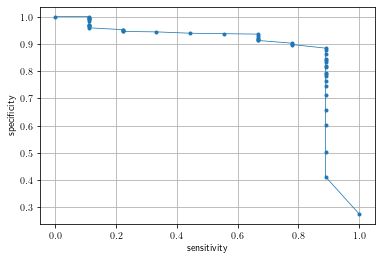

In [31]:
df_trainO, df_tuneO, df_testO = dset.get_data(split_age=AgeSplit.OLD ,**judg_calls)
feature_namesO = list(df_trainO)
for col in dset.get_meta_keys() + [dset.get_outcome_name()]:
    try:
        feature_namesO.remove(col)
    except ValueError:
        pass
    
rulefit = imodels.RuleFitClassifier(max_rules=10)
rulefit.fit(df_trainO.loc[:, feature_namesO], df_trainO.outcome, feature_names=feature_namesO)

sy, ty = predict_and_save(rulefit, 'rulefit',
                                   df_trainO.loc[:, feature_namesO],
                                   df_tuneO.loc[:, feature_namesO],
                                   df_trainO.outcome,
                                   df_tuneO.outcome)

In [32]:
rules = rulefit.get_rules()
rules = rules[rules['type']!='linear']
rules = rules.sort_values('importance', ascending=False) 
rules

,rule,type,coef,support,importance
24,Amnesia_verb_91 <= 0.5 and Vomit <= 0.5,rule,-1.087372,0.901639,0.323821
25,GCSTotal > 0.5 and SFxBas <= 0.5,rule,-1.394140,0.951913,0.298278
23,Seiz <= 0.5 and AMS <= 0.5,rule,-0.659152,0.834973,0.244681
22,LOCSeparate <= 0.5,rule,-0.205351,0.677049,0.096023
27,Seiz <= 0.5 and SFxBas <= 0.5,rule,-0.498512,0.983607,0.063303
20,SFxBas <= 0.5 and Hema <= 0.5,rule,-0.127922,0.682514,0.059547
26,High_impact_InjSev_2 > 0.5 and GCSTotal > 0.5,rule,-0.070096,0.654098,0.033342
21,Vomit <= 0.5 and Hema <= 0.5,rule,-0.055793,0.641530,0.026755
